In [0]:
#!pip install tensorflow-gpu
import tensorflow as tf
import tensorflow.keras as keras
import os
import sys
import numpy as np
import pandas as pd
import random
import json
import functools

!pip install umap-learn
import umap

from scipy.spatial.distance import cdist
from skimage import io
from matplotlib import pyplot as plt
from multiprocessing import Pool, cpu_count

if not os.path.exists('./ngrok'):
    !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
    !unzip ngrok-stable-linux-amd64.zip

plt.rcParams["axes.grid"] = False

!pip install ipython-autotime
%load_ext autotime

# Load the TensorBoard notebook extension
%load_ext tensorboard

print('TENSORFLOW VERSION:',tf.__version__)

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
TENSORFLOW VERSION: 1.14.0
time: 6.78 s


In [0]:
# Set up different folders for different runs of the model
!rm -r sample_data
#!rm -r './models'

models_folder = './models'
model_number = 0

if not os.path.exists(models_folder):
    os.makedirs(models_folder)

rm: cannot remove 'sample_data': No such file or directory
time: 1.58 s


# TENSORBOARD

In [0]:
# TENSORBOARD LINK
LOG_DIR = models_folder
#LOG_DIR = "resnet50_da_10h"
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

get_ipython().system_raw('./ngrok http 6006 &')

! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://14c6a4e9.ngrok.io
time: 1.75 s


In [0]:
#%tensorboard --logdir $LOG_DIR

time: 2.02 ms


# DRIVE FILES

In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 2.71 ms


In [0]:
# TFRecords paths
citius_tfrecords = './drive/My Drive/CiTius/TFRecords/'
citius_jsons = './drive/My Drive/CiTius/JSONs/'

train_file = citius_tfrecords + 'Bark-dataset-Train.tfrecord'
test_file = citius_tfrecords + 'Bark-dataset-Test.tfrecord'
anomalies_test_file = citius_tfrecords + 'Bark-Anomalies-Test.tfrecord'

time: 4.74 ms


# PARAMS

In [0]:
# PARAMS (hyperparameters)

# General params
#######################################################

num_epochs = -1 # 30 by default

filters = [32, 64, 128]
crop_ratio = 0.95

train_data_augmentation = 'soft' # None/'soft'/'hard'

samples_for_evaluation = 50
image_size = 256
input_size = 128
crop_size = 64

#-----------------------------------------------------#


# WARM START VARIABLES FROM A MODEL WHEN FINE-TUNING
warm_dir = './content/drive/My Drive/CiTius/Trained-Models/...'
make_warm_start = False
train_after_warm_start = False

# LOAD MODEL ONLY WHEN PREDICTING/EVALUATING AND NOT FOR TRAINING
load_model = True
train_loaded = False
reload_model = False
assert not (make_warm_start and load_model),'Cannot load pretrained model and warm start variables at the same time'

if load_model:
    download_path = '/content/drive/My\ Drive/CiTius/Trained-Models/INP-SDA-64'
    copy_path = '/content/models/'
    model_path = copy_path + download_path.split('/')[-1]
    if reload_model:
        !rm -r $model_path
    if not os.path.exists(model_path):
        !cp -r $download_path $copy_path
#######################################################

batch_size = 16
shuffle_size = 1000
eval_batch_size = batch_size
num_channels = 3
learning_rate = 1e-4

# Save checkpoints during training params
save_summary_steps = save_checkpoints_steps = 600
min_secs_eval = 5.0

# Early stopping param
max_steps_without_decrease = 9999999
run_every_steps = save_checkpoints_steps # Run validation every ? steps

# Features when reading Examples
features = {
    'rows': tf.FixedLenFeature([], tf.int64),
    'cols': tf.FixedLenFeature([], tf.int64),
    'channels': tf.FixedLenFeature([], tf.int64),
    'image': tf.FixedLenFeature([], tf.string),
    'label': tf.FixedLenFeature([], tf.int64)
}

time: 32 ms


# TFRECORD EXTRACTOR

In [0]:
# CLASS TO EXTRACT IMAGES FROM A TFRECORD AND RETURN IN A DATASET
class TFRecordExtractor:
    def __init__(self, tfrecord_file):
        self.tfrecord_file = os.path.abspath(tfrecord_file)

    def _extract_fn(self, tfrecord):
        # Extract the data record
        sample = tf.parse_single_example(tfrecord, features)

        # cast image [0, 255] to [0.0, 1.0]
        image = tf.image.decode_image(sample['image'], dtype=tf.uint8)
        image = tf.cast(image, tf.float32)
        image = image / 255
        img_shape = tf.stack([sample['rows'], sample['cols'], sample['channels']])
        #label = sample['label']
        #label = tf.cast(label, tf.int64)
        #filename = sample['filename']
        
        return image

    def extract_image(self):

        # Pipeline of dataset
        dataset = tf.data.TFRecordDataset([self.tfrecord_file])
        dataset = dataset.map(self._extract_fn)
        
        return dataset

time: 11.5 ms


# DATASET LOADING & INPUT_FN

In [0]:
crop_ratio = 0.25
def random_crop(image):
    crop_size = tf.random_uniform(shape=[], minval=150, maxval=200, dtype=tf.int32)
    image = tf.image.random_crop(image, size=(crop_size,crop_size,3))
    image = tf.image.resize(image, size=(image_size,image_size))
    return image

def all_data_augmentations(image):
    #do_crop = tf.random_uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)
    #image = tf.cond(tf.less(do_crop, crop_ratio), lambda: random_crop(image), lambda: image)

    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if train_data_augmentation == 'hard':
        image = tf.image.random_brightness(image, max_delta=0.25)
        image = tf.image.random_saturation(image, lower=0.75, upper=1.25)
        image = tf.image.random_contrast(image, lower=0.75, upper=1.25)
        image = tf.image.random_hue(image, max_delta=0.15)
    
    return image

def apply_data_augmentations(dataset):
    
    dataset = dataset.map(all_data_augmentations, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    return dataset

time: 13.7 ms


In [0]:
def load_dataset(filePath):
    t = TFRecordExtractor(filePath)
    dataset = t.extract_image()
    return dataset

def load_multiple_datasets(paths):
    final_dataset = None
    for path in paths:
        dataset = load_dataset(path)
        final_dataset = final_dataset.concatenate(dataset) if final_dataset != None else dataset
    return final_dataset

def get_patches(image, stride=crop_size):
    ksizes=[1,input_size,input_size,1]
    strides=[1,stride,stride,1]
    rates=[1,1,1,1]
    patches = tf.image.extract_image_patches(tf.reshape(image, (1, image_size, image_size, num_channels)),ksizes,strides,rates,padding='VALID')
    return tf.reshape(patches, (-1, input_size, input_size, num_channels))

def padding_and_get_patches(image, stride=int(crop_size/2)):
    padding_expansion = 30# int( (input_size - crop_size)/2 )
    paddings = tf.constant([[padding_expansion, padding_expansion],
                            [padding_expansion, padding_expansion],
                            [0, 0]])
    image = tf.pad(image, paddings, mode='REFLECT')
    
    ksizes=[1,input_size,input_size,1]
    strides=[1,stride,1,1]
    rates=[1,1,1,1]
    patches = tf.image.extract_image_patches(tf.reshape(image, (1, image_size+2*padding_expansion, image_size+2*padding_expansion, num_channels)),ksizes,strides,rates,padding='VALID')
    return tf.reshape(patches, (-1, input_size, input_size, num_channels))

time: 17.3 ms


In [0]:
"""Create the input data pipeline using `tf.data`"""
def train_input_fn(train_file):
    if isinstance(train_file, list):
        dataset = load_multiple_datasets(train_file)
    else:
        dataset = load_dataset(train_file)
    
    if train_data_augmentation is not None:
        dataset = apply_data_augmentations(dataset)
    
    dataset = dataset.shuffle(buffer_size=shuffle_size)
    dataset = dataset.map(get_patches, num_parallel_calls=tf.data.experimental.AUTOTUNE).apply(tf.data.experimental.unbatch())
    dataset = dataset.repeat(num_epochs)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(1)  # make sure you always have one batch ready to serve
    return dataset

def single_test_input_fn(test_file):
    dataset = load_dataset(test_file)
    dataset = dataset.take(1)
    dataset = dataset.map(get_patches, num_parallel_calls=tf.data.experimental.AUTOTUNE).apply(tf.data.experimental.unbatch())
    dataset = dataset.batch(eval_batch_size)
    dataset = dataset.prefetch(1)  # make sure you always have one batch ready to serve
    return dataset

def test_input_fn(test_file):
    dataset = load_dataset(test_file)
    dataset = dataset.map(get_patches, num_parallel_calls=tf.data.experimental.AUTOTUNE).apply(tf.data.experimental.unbatch())
    dataset = dataset.batch(eval_batch_size)
    dataset = dataset.prefetch(1)  # make sure you always have one batch ready to serve
    return dataset

def reduced_test_input_fn(test_file, samples):
    dataset = load_dataset(test_file)
    dataset = dataset.map(get_patches, num_parallel_calls=tf.data.experimental.AUTOTUNE).apply(tf.data.experimental.unbatch())
    dataset = dataset.take(samples)
    dataset = dataset.batch(eval_batch_size)
    dataset = dataset.prefetch(1)  # make sure you always have one batch ready to serve
    return dataset

def reduced_train_input_fn(train_file, samples):
    dataset = load_dataset(train_file)
    dataset = dataset.map(get_patches, num_parallel_calls=tf.data.experimental.AUTOTUNE).apply(tf.data.experimental.unbatch())
    dataset = dataset.take(samples)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(1)  # make sure you always have one batch ready to serve
    return dataset

def predict_input_fn(test_file, stride=int(crop_size/4)):
    dataset = load_dataset(test_file)
    dataset = dataset.map(lambda x: get_patches(x, stride), num_parallel_calls=tf.data.experimental.AUTOTUNE).apply(tf.data.experimental.unbatch())
    dataset = dataset.batch(eval_batch_size)
    dataset = dataset.prefetch(1)  # make sure you always have one batch ready to serve
    return dataset

time: 44 ms


# MODEL ARCHITECTURE & MODEL_FN

In [0]:
def inpainting(inputs, kernel_size=3, filters=[32, 64, 128], dilation_rates=[2, 4, 8, 16], stride_decode=2):

    # Input shape layers
    for filter in filters[:-1]:
        inputs = tf.layers.conv2d(inputs, filter, kernel_size, padding='same', activation=tf.nn.relu)
    # Reduce shape layer
    inputs = tf.layers.conv2d(inputs, filters[-1], kernel_size, strides=2, padding='same', activation=tf.nn.relu)

    # Reduced shape layer
    for i in range(2):
        inputs = tf.layers.conv2d(inputs, filters[-1], kernel_size, padding='same', activation=tf.nn.relu)
    # Dilated convolutions
    for dilation in dilation_rates:
        inputs = tf.layers.conv2d(inputs, filters[-1], kernel_size, dilation_rate=dilation, padding='same', activation=tf.nn.relu)
    # Last reduced shape convolutions
    for i in range(2):
        inputs = tf.layers.conv2d(inputs, filters[-1], kernel_size, padding='same', activation=tf.nn.relu)
    
    # Upscaling convolution
    inputs = tf.layers.conv2d_transpose(inputs, filters[-2], kernel_size, stride_decode, padding='same', activation=tf.nn.relu)
    # Last convolutions
    for i in range(len(filters)-3,-1,-1):
        inputs = tf.layers.conv2d(inputs, filters[i], kernel_size, padding='same', activation=tf.nn.relu)
    # Last convolution of the network
    results = tf.layers.conv2d(inputs, num_channels, kernel_size, padding='same', activation=None)


    return results

time: 18.1 ms


In [0]:
"""Define the model"""
def model_fn(features, mode):
    """Model function for tf.estimator
    Args:
        features: input batch of images
        mode: can be one of tf.estimator.ModeKeys.{TRAIN, EVAL, PREDICT}
    Returns:
        model_spec: tf.estimator.EstimatorSpec object
    """
    is_training = (mode == tf.estimator.ModeKeys.TRAIN)

    images = features
    originals = tf.reshape(images, shape=(-1, input_size, input_size, num_channels))
    assert originals.shape[1:] == [input_size, input_size, num_channels], "{}".format(originals.shape)
    # -----------------------------------------------------------
    
    results = {
        'originals' : originals
    }
    
    # Central crop of crop_size
    
    '''
    offset = int( (image_size-crop_size)/2 )
    # USE SCATTER_ND HERE TO PUT ZEROS IN CENTER CROP
    #indices = tf.constant([[0], [2]])
    updates = tf.constant([[[5, 5, 5, 5], [6, 6, 6, 6],
                            [7, 7, 7, 7], [8, 8, 8, 8]],
                           [[5, 5, 5, 5], [6, 6, 6, 6],
                            [7, 7, 7, 7], [8, 8, 8, 8]]])
    shape = tf.constant([4, 4, 4])
    scatter = tf.scatter_nd(indices, updates, shape)
    '''

    #cropped_images = originals[:,offset:offset+crop_size,offset:offset+crop_size,:].assign(0)
    
    central_crops = tf.image.central_crop(originals, central_fraction=crop_size/input_size)
    padding_expansion = int( (input_size-crop_size)/2 )
    paddings = tf.constant([[0, 0],
                            [padding_expansion, padding_expansion],
                            [padding_expansion, padding_expansion],
                            [0, 0]])
    central_crops = tf.pad(central_crops, paddings, mode='CONSTANT')
    cropped_images = originals - central_crops
    assert cropped_images.shape[1:] == [input_size, input_size, num_channels], "{}".format(cropped_images.shape)
   
    results['inputs'] = cropped_images
    
    with tf.variable_scope('model'):
        outputs = inpainting(cropped_images, kernel_size=3, filters=filters)
        
    assert outputs.shape[1:] == [input_size, input_size,num_channels],"{}".format(outputs.shape)
    results['outputs'] = outputs
    
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        predictions = {
            'originals' : results['originals'],
            'outputs': results['outputs']
        }
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    
    # -----------------------------------------------------------
    central_crops_outputs = tf.image.central_crop(outputs, central_fraction=crop_size/input_size)
    central_crops_outputs = tf.pad(central_crops_outputs, paddings, mode='CONSTANT')
    outputs_cropped_images = outputs - central_crops_outputs
    assert outputs_cropped_images.shape[1:] == [input_size, input_size, num_channels], "{}".format(outputs_cropped_images.shape)
    
    #loss = crop_ratio*tf.reduce_mean(tf.nn.l2_loss(central_crops - central_crops_outputs)) + (1-crop_ratio)*tf.reduce_mean(tf.nn.l2_loss(cropped_images - outputs_cropped_images))
    loss = crop_ratio*tf.reduce_sum(tf.losses.absolute_difference(central_crops, central_crops_outputs, reduction=tf.losses.Reduction.NONE)) + (1-crop_ratio)*tf.reduce_sum(tf.losses.absolute_difference(cropped_images, outputs_cropped_images, reduction=tf.losses.Reduction.NONE))

    
    if mode == tf.estimator.ModeKeys.EVAL:
        return tf.estimator.EstimatorSpec(mode, loss=loss)

    
    # Loss summary for train set
    tf.summary.scalar('loss', loss)

    tf.summary.image('train_image', originals, max_outputs=1)

    # Define training step that minimizes the loss with the Adam optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate)
    global_step = tf.train.get_global_step()
    train_op = optimizer.minimize(loss, global_step=global_step)

    return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)

time: 58.4 ms


# TRAIN AND EVALUATE

In [0]:
# MODEL INITIALIZATION AND TRAIN/EVALUATE

tf.reset_default_graph()

tf.logging.set_verbosity(tf.logging.WARN)

if not load_model:
    model_number += 1
    model_dir = models_folder+"/model_"+str(model_number)
else:
    model_dir = model_path

# Define the model
tf.logging.info("Creating the model...")

#mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/device:CPU:0","/device:GPU:0"])
config = tf.estimator.RunConfig(
                            tf_random_seed=200,
                            model_dir=model_dir,
                            save_summary_steps=save_summary_steps,
                            save_checkpoints_steps=save_checkpoints_steps,
                            train_distribute=None,
                            eval_distribute=None)
config = config.replace(keep_checkpoint_max=1)

if make_warm_start:
    vars_to_initialize = ["^(?!.*(Adam|beta1_power|beta2_power|dense)).*$"] if 'ImageNet' in warm_dir else ["model.*"]
    ws = tf.estimator.WarmStartSettings(ckpt_to_initialize_from=warm_dir, vars_to_warm_start=vars_to_initialize)
    estimator = tf.estimator.Estimator(model_fn, config=config, warm_start_from=ws)
else:
    estimator = tf.estimator.Estimator(model_fn, config=config)

# EVALUATION
tf.logging.info("Evaluation on test set.")
res = estimator.evaluate(lambda: single_test_input_fn(test_file))
for key in res:
    print("{}: {}".format(key, res[key]))


if (not make_warm_start and not load_model) or (make_warm_start and train_after_warm_start) or (load_model and train_loaded):
    # Train the model
    tf.logging.info("Starting training for {} epoch(s).".format(num_epochs))

    # Set up an early stopping hook for the loss
    if not os.path.exists(estimator.eval_dir()): os.makedirs(estimator.eval_dir())

    early_stopping = tf.estimator.experimental.stop_if_no_decrease_hook(
        estimator,
        metric_name='loss',
        max_steps_without_decrease=max_steps_without_decrease,
        min_steps=10,
        run_every_secs = None,
        run_every_steps = run_every_steps)

    # Train and Evaluate at the same time (producing checkpoints and evaluating for summary)
    train_spec = tf.estimator.TrainSpec(input_fn=lambda: train_input_fn(train_file), hooks=[early_stopping])
    eval_spec = tf.estimator.EvalSpec(input_fn=lambda: single_test_input_fn(test_file), throttle_secs = min_secs_eval)
    results = tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)
    print(results)

loss: 3518.310791015625
global_step: 324000
time: 1.27 s


In [0]:
# EVALUATION POST TRAINING

tf.logging.info("Evaluation on test set.")
res = estimator.evaluate(lambda: single_test_input_fn(test_file))
for key in res:
    print("{}: {}".format(key, res[key]))

loss: 3518.310546875
global_step: 324000
time: 1.45 s


# PREDICT

In [0]:
# PREDICT THE TEST SET
%reset_selective -f "^test_results$"
test_results = list(estimator.predict(input_fn=lambda: reduced_test_input_fn(test_file, samples=samples_for_evaluation), yield_single_examples=True))

# GET THE EMBEDDING AND OUTPUT IMAGE FOR ALL THE TEST SET
results_to_append = []

count = 0
for elem in test_results:
    input = elem['originals']
    output = elem['outputs']
    input = np.reshape(input, newshape= (input.shape[0], input.shape[1], 3) )
    output = np.reshape(output, newshape= (output.shape[0], output.shape[1], 3) )
    count += 1
    results_to_append.append( (input, count, output) )
    
test_results = np.array(results_to_append)
print('Test results from the INPAINTING:', test_results.shape)



# PREDICT THE REDUCED TRAIN SET
%reset_selective -f "^train_results$"
train_results = list(estimator.predict(input_fn=lambda: reduced_train_input_fn(train_file, samples=samples_for_evaluation), yield_single_examples=True))

# GET THE EMBEDDING AND OUTPUT IMAGE FOR THE REDUCED TRAIN SET
results_to_append = []

count = 0
for elem in train_results:
    input = elem['originals']
    output = elem['outputs']
    input = np.reshape(input, newshape= (input.shape[0], input.shape[1], 3) )
    output = np.reshape(output, newshape= (output.shape[0], output.shape[1], 3) )
    count += 1
    results_to_append.append( (input, count, output) )
    
train_results = np.array(results_to_append)
print('Train results from the INPAINTING:',train_results.shape)

Test results from the INPAINTING: (50, 3)
Train results from the INPAINTING: (50, 3)
time: 3.24 s


# RESULTS VISUALIZATION

In [0]:
# FUNCTION TO VISUALIZE INPUT AND OUTPUT IMAGES OF THE INPAINTING
def visualize_results(results, number):
    assert number>0
    assert results.shape[0]>0 and results.shape[1]>0
    
    for i in range(number):
        result = results[i]
        input = result[0]
        count = result[1]
        output = result[2]
        
        f, axarr = plt.subplots(ncols=3, nrows=1, figsize=(10, 7))
        axarr[0].imshow(input)
        axarr[0].set_title('Input-'+str(count))
        axarr[1].imshow(output)
        axarr[1].set_title('Output-'+str(count))
        axarr[2].imshow(abs(input-output))
        axarr[2].set_title('Absolute difference')
        plt.show()

time: 20.4 ms


W0717 10:38:53.424577 139628686710656 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


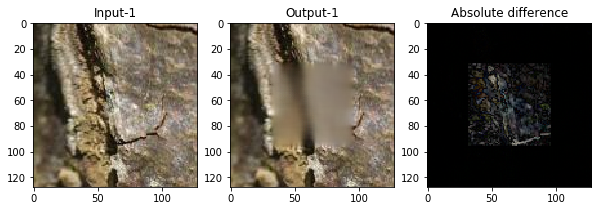

W0717 10:38:54.016614 139628686710656 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


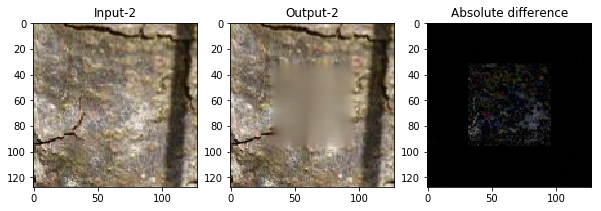

W0717 10:38:54.614516 139628686710656 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


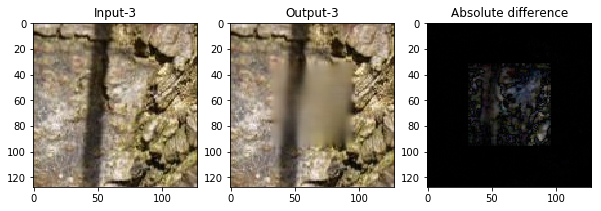

W0717 10:38:55.236805 139628686710656 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


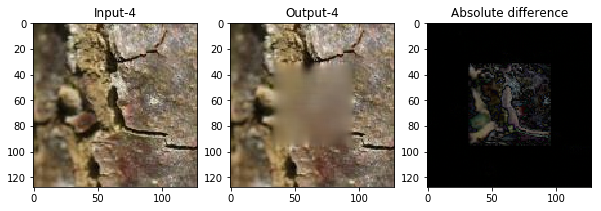

W0717 10:38:55.847094 139628686710656 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


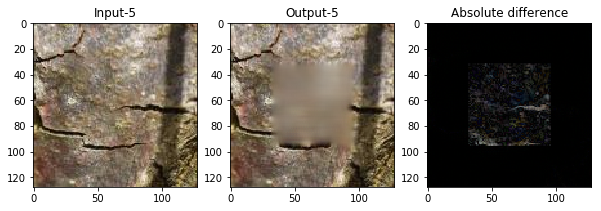

time: 3.02 s


In [0]:
# VISUALIZE SOME TEST RESULTS
visualize_results(test_results, 5)

W0717 10:38:56.504506 139628686710656 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


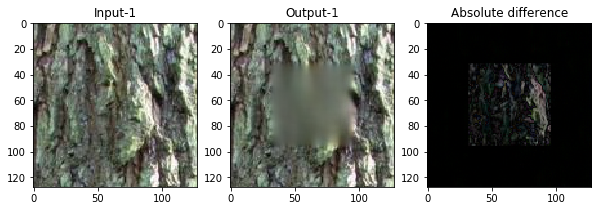

W0717 10:38:57.112606 139628686710656 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


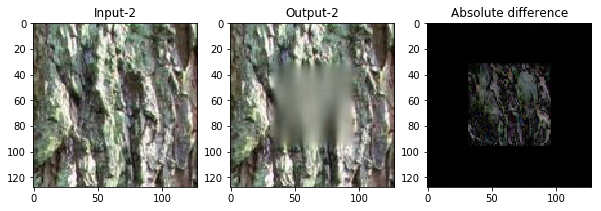

W0717 10:38:57.880424 139628686710656 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


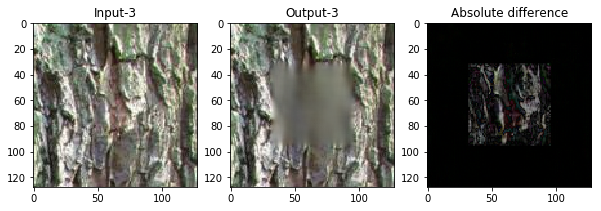

W0717 10:38:58.627711 139628686710656 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


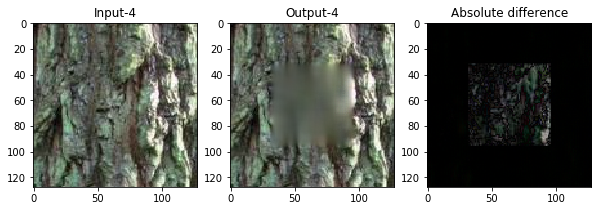

W0717 10:38:59.389308 139628686710656 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


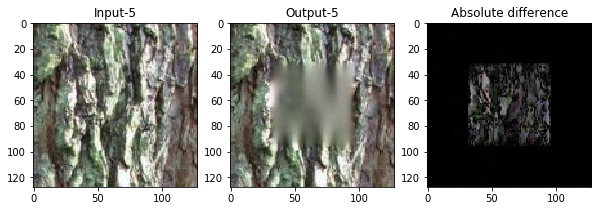

time: 3.68 s


In [0]:
# VISUALIZE SOME TRAIN RESULTS
visualize_results(train_results, 5)

# ANOMALY DATASET AND EVALUATION

In [0]:
#-------------------------PARAMS--------------------------#
sliding_window_stride = 16
dataset_name = 'Bark-External-Quantitative'
only_differences = True

num_anomalies_images = 500
#---------------------------------------------------------#


#def predict_quantitative(dataset_name, sliding_window_stride, num_anomalies_images=500, only_differences=True):
def json_to_dict(path):
    with open(path) as json_file:  
        data = json.load(json_file)
    return data

def crop_center(img):
    img = np.reshape(img, [input_size, input_size, num_channels])
    y,x,channels = img.shape
    startx = x//2-(crop_size//2)
    starty = y//2-(crop_size//2)    
    return img[starty:starty+crop_size,startx:startx+crop_size,:]

anomalies_quantitative_file = citius_tfrecords + dataset_name + '.tfrecord'
json_file = citius_jsons + dataset_name + '.json'
print(json_file)

%reset_selective -f "^centers$"
%reset_selective -f "^anomalies_results$"

centers = json_to_dict(json_file)
anomalies_results = estimator.predict(input_fn=lambda: predict_input_fn(anomalies_quantitative_file, stride=sliding_window_stride), yield_single_examples=True)


results_to_append = []
count = 0

if not only_differences:
    ########################SAVE INPUTS, COUNTS AND OUTPUTS############################

    for elem in anomalies_results:
        input = elem['originals']
        output = elem['outputs']
        input = np.reshape(input, newshape= (input.shape[0], input.shape[1], 3) )
        output = np.reshape(output, newshape= (output.shape[0], output.shape[1], 3) )
        count += 1
        results_to_append.append( (input, count, output) )

    anomalies_results = np.array(results_to_append)
    print('Anomalies results from the INPAINTING:', anomalies_results.shape)
    anomalies_results = np.split(anomalies_results, num_anomalies_images)
    print('Test results after splitting:', len(anomalies_results))
    print('Shape of a split:', anomalies_results[0].shape)
    num_windows = int(anomalies_results[0].shape[0]**(1/2))
    print(str(num_windows),'x',str(num_windows),'=',str(anomalies_results[0].shape[0]),'windows per image')
    print('Sliding window stride:',sliding_window_stride)

else:
    #########################ONLY SAVE DIFFERENCES AND ORDERS###########################
    num_windows = int( (image_size-input_size)/sliding_window_stride )+1
    image_count = 0
    
    def generate_indexs():
        global image_count
        
        for i in range(num_anomalies_images):

            offset = image_count*(num_windows**2)
            def generate_differences():
                n = 0
                for elem in anomalies_results:
                    #elem = anomalies_results[n + offset]
                    input = elem['originals']
                    output = elem['outputs']
                    input = np.reshape(input, newshape= (input.shape[0], input.shape[1], 3) )
                    output = np.reshape(output, newshape= (output.shape[0], output.shape[1], 3) )

                    cropped_input = crop_center(input)
                    cropped_output = crop_center(output)
                    difference = np.abs(cropped_input - cropped_output)
                    #difference = np.apply_over_axes(np.sum, difference, axes=[0,1,2])
                    difference = np.sum(difference)
                    #print(difference)
                    n += 1
                    yield difference
                    if n == num_windows**2: break

            patches_difference = list(generate_differences())
            difference_candidates, sorted_indexs = np.sort(np.array(patches_difference))[::-1], np.argsort(np.array(patches_difference))[::-1]
            yield difference_candidates, sorted_indexs
            #results_to_append.append( (difference_candidates, sorted_indexs) )
            image_count += 1

    anomalies_results = np.squeeze(np.array(list(generate_indexs())))
    print('Anomalies results from the INPAINTING:', anomalies_results.shape)
    print('Differences results after splitting:', len(anomalies_results))
    print('Shape of a split:', anomalies_results[0].shape)
    #print(str(num_windows),'x',str(num_windows),'=',str(anomalies_results[0].shape[1]),'windows per image')
    #print('Sliding window stride:',sliding_window_stride)
    #assert int(anomalies_results[0].shape[1]**(1/2)) == num_windows,'Error in num of windows per axis'

    #return anomalies_results, centers

./drive/My Drive/CiTius/JSONs/Bark-External-Quantitative.json
Anomalies results from the INPAINTING: (500, 2, 81)
Differences results after splitting: 500
Shape of a split: (2, 81)
time: 4min 40s


In [0]:
def append_df_to_excel(filename, df, sheet_name='Sheet1', startrow=None,
                       truncate_sheet=False, 
                       **to_excel_kwargs):
    """
    Append a DataFrame [df] to existing Excel file [filename]
    into [sheet_name] Sheet.
    If [filename] doesn't exist, then this function will create it.

    Parameters:
      filename : File path or existing ExcelWriter
                 (Example: '/path/to/file.xlsx')
      df : dataframe to save to workbook
      sheet_name : Name of sheet which will contain DataFrame.
                   (default: 'Sheet1')
      startrow : upper left cell row to dump data frame.
                 Per default (startrow=None) calculate the last row
                 in the existing DF and write to the next row...
      truncate_sheet : truncate (remove and recreate) [sheet_name]
                       before writing DataFrame to Excel file
      to_excel_kwargs : arguments which will be passed to `DataFrame.to_excel()`
                        [can be dictionary]

    Returns: None
    """
    from openpyxl import load_workbook

    import pandas as pd

    # ignore [engine] parameter if it was passed
    if 'engine' in to_excel_kwargs:
        to_excel_kwargs.pop('engine')

    writer = pd.ExcelWriter(filename, engine='openpyxl')

    try:
        # try to open an existing workbook
        writer.book = load_workbook(filename)

        # get the last row in the existing Excel sheet
        # if it was not specified explicitly
        if startrow is None and sheet_name in writer.book.sheetnames:
            startrow = writer.book[sheet_name].max_row

        # truncate sheet
        if truncate_sheet and sheet_name in writer.book.sheetnames:
            # index of [sheet_name] sheet
            idx = writer.book.sheetnames.index(sheet_name)
            # remove [sheet_name]
            writer.book.remove(writer.book.worksheets[idx])
            # create an empty sheet [sheet_name] using old index
            writer.book.create_sheet(sheet_name, idx)

        # copy existing sheets
        writer.sheets = {ws.title:ws for ws in writer.book.worksheets}
    except FileNotFoundError:
        # file does not exist yet, we will create it
        pass

    if startrow is None:
        startrow = 0

    # write out the new sheet
    df.to_excel(writer, sheet_name, startrow=startrow, **to_excel_kwargs)

    # save the workbook
    writer.save()

def visualize_candidates(index_image, indexs):
    to_show = []
    image_split = anomalies_results[index_image]
    for i in indexs:
        input = image_split[i,0]
        to_show.append( (input, i) )
        if len(to_show)%4 == 0:
            f, axarr = plt.subplots(ncols=4, nrows=1, figsize=(10, 7))
            axarr[0].imshow(to_show[0][0])
            axarr[0].set_title(to_show[0][1])
            axarr[1].imshow(to_show[1][0])
            axarr[1].set_title(to_show[1][1])
            axarr[2].imshow(to_show[2][0])
            axarr[2].set_title(to_show[2][1])
            axarr[3].imshow(to_show[3][0])
            axarr[3].set_title(to_show[3][1])
            plt.show()
            to_show = []
            
def memoize(f):
    memo = {}
    def helper(x):
        if x not in memo:            
            memo[x] = f(x)
        return memo[x]
    return helper

@memoize
def compute_worst_inpaintings(index):
    results = anomalies_results[index]
    cropped_inputs = np.array(list(map(crop_center, results[:,0])))
    cropped_outputs = np.array(list(map(crop_center, results[:,2])))
    differences = np.abs(cropped_inputs - cropped_outputs)
    differences = np.apply_over_axes(np.sum, differences, axes=[1,2,3])
    differences = np.squeeze(differences)
    #print(differences.shape)
    #print(differences)
    '''for i in range(differences.shape[0]):
        differences[i] = np.sum(differences[i])
        print(differences[i])
        '''
    difference_candidates, sorted_indexs = np.sort(differences)[::-1], np.argsort(differences)[::-1]
    #print(candidates)
    #print(indexs)
    if top >= 0: return sorted_indexs[:top], difference_candidates[:top]
    return sorted_indexs, difference_candidates

def compute_and_visualize_worsts(image_index, top=16, differences_stored=only_differences):
    assert not differences_stored,'Patches not stored for visualization'
    candidate_indexs, candidate_differences = compute_worst_inpaintings(anomalies_results, image_index)
        
    if top >= 0: candidate_indexs, candidate_differences = candidate_indexs[:top], candidate_differences[:top]
    print('Indexs of the candidates:',candidate_indexs)
    print('Absolute differences of the candidates:',candidate_differences)
    visualize_candidates(image_index, candidate_indexs)
    
def detect_anomaly(image_index, outlier_threshold=-9999, top_anomalies=-1, differences_stored=only_differences):
    if not differences_stored: candidate_indexs, candidate_differences = compute_worst_inpaintings(anomalies_results, image_index)
    else: candidate_indexs, candidate_differences = anomalies_results[image_index,1], anomalies_results[image_index,0]
    
    mean, std = np.mean(candidate_differences), np.std(candidate_differences)
    threshold_index = np.where(candidate_differences >= mean+outlier_threshold*std)[0]
    
    if len(threshold_index) <= 0:
        return [], []
    #print(threshold_index)
    threshold_index = threshold_index[-1]+1
    
    candidate_indexs, candidate_differences = candidate_indexs[:threshold_index], candidate_differences[:threshold_index]
    if top_anomalies >= 0: return candidate_indexs[:top_anomalies], candidate_differences[:top_anomalies]
    return candidate_indexs, candidate_differences

def check_detections(image_index, detected_indexs, center_tolerance=0):
    assert center_tolerance >= 0,'Center tolerance must be >= 0'
    if len(detected_indexs) <= 0: return 0
    
    center = centers[str(image_index)]
    
    anomaly_detected = False
    i = 0
    if center_tolerance == 0:
        while not anomaly_detected and i < len(detected_indexs):
            index_candidate = detected_indexs[i]
            start_row, start_col = int(index_candidate/num_windows)*sliding_window_stride, (index_candidate % num_windows)*sliding_window_stride
            end_row, end_col = start_row+input_size, start_col+input_size
            anomaly_detected = (start_row <= center[0] <= end_row) and (start_col <= center[1] <= end_col)
            #print(center)
            #print('Rows:',start_row, end_row)
            #print('Cols:',start_col, end_col)
            
            i += 1
    else:
        raise NotImplementedError
    
    return int(anomaly_detected)

def evaluate_anomaly_image(image_index, top_anomalies=-1, outlier_threshold=-9999, center_tolerance=0, verbose=False):
    anomaly_indexs, anomaly_differences = detect_anomaly(image_index, outlier_threshold=outlier_threshold, top_anomalies=top_anomalies)
    detected = check_detections(image_index, anomaly_indexs, center_tolerance)
    
    if verbose:
        print('Indexs of the anomalies:',anomaly_indexs)
        print('Absolute differences of the anomalies:',anomaly_differences)
        print('Detected anomaly?',detected==1)
        
    return detected

def evaluate_all_anomalies_images(top_anomalies=-1, outlier_threshold=-9999, center_tolerance=0, verbose=False):
    sum = 0
    for image_index in range(len(anomalies_results)):
        detected = evaluate_anomaly_image(image_index, top_anomalies, outlier_threshold, center_tolerance)
        sum += detected
        if verbose:
            print('Image num',image_index,'detected anomaly?',detected==1)
    
    return sum*100/len(anomalies_results)

time: 254 ms


In [0]:
#compute_and_visualize_worsts(3, top=16)

time: 1.15 ms


# ACCURACY COMPUTATIONS

In [0]:
max_top = min(50, num_windows**2) + 1
columns = ['Top '+str(n) for n in range(1, 51)]
df = pd.DataFrame(columns=columns)
print(df)

Empty DataFrame
Columns: [Top 1, Top 2, Top 3, Top 4, Top 5, Top 6, Top 7, Top 8, Top 9, Top 10, Top 11, Top 12, Top 13, Top 14, Top 15, Top 16, Top 17, Top 18, Top 19, Top 20, Top 21, Top 22, Top 23, Top 24, Top 25, Top 26, Top 27, Top 28, Top 29, Top 30, Top 31, Top 32, Top 33, Top 34, Top 35, Top 36, Top 37, Top 38, Top 39, Top 40, Top 41, Top 42, Top 43, Top 44, Top 45, Top 46, Top 47, Top 48, Top 49, Top 50]
Index: []
time: 17.8 ms


In [0]:
def compute_accuracy(threshold):
    if threshold < 0: threshold_label = 'All'
    else: threshold_label = (str(threshold))[:3]
    model_name = download_path.split('/')[-1] + '-' + threshold_label + '-' + str(sliding_window_stride)
    
    accuracies = {}
    for n in range(1, max_top):
        accuracy = evaluate_all_anomalies_images(top_anomalies=n, outlier_threshold=threshold, verbose=False)
        accuracies[columns[n-1]] = accuracy

        #print('Top',n,'accuracy:',accuracy)
        if accuracy >= 100: break
    
    return model_name, pd.Series(accuracies)

#anomalies_results, centers = predict_quantitative('Bark-Colours-Quantitative',32)

max_threshold = 6.0
thresholds = np.insert(np.arange(0.0, max_threshold, 0.1), 0, -np.inf)
print('Available cores:',cpu_count())
pool = Pool(4)

thresholds = pool.map(compute_accuracy, thresholds)
pool.close()
pool.join()

for model_name, series in thresholds:
    df.loc[model_name] = series

Available cores: 4


Process ForkPoolWorker-38:
Process ForkPoolWorker-40:
Process ForkPoolWorker-37:
Process ForkPoolWorker-39:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "<ipython-input-86-110884

KeyboardInterrupt: ignored

time: 12.1 s


In [0]:
#print(thresholds)
print(df)

                   Top 1  Top 2  Top 3  Top 4  ...  Top 47  Top 48  Top 49  Top 50
INP-SDA-64-All-16   77.2   82.4   85.8   88.2  ...     NaN     NaN     NaN     NaN
INP-SDA-64-0.0-16   77.2   82.4   85.8   88.2  ...     NaN     NaN     NaN     NaN
INP-SDA-64-0.1-16   77.2   82.4   85.8   88.2  ...     NaN     NaN     NaN     NaN
INP-SDA-64-0.2-16   77.2   82.4   85.8   88.2  ...     NaN     NaN     NaN     NaN
INP-SDA-64-0.3-16   77.2   82.4   85.8   88.2  ...     NaN     NaN     NaN     NaN
INP-SDA-64-0.4-16   77.2   82.4   85.8   88.2  ...     NaN     NaN     NaN     NaN
INP-SDA-64-0.5-16   77.2   82.4   85.8   88.2  ...     NaN     NaN     NaN     NaN
INP-SDA-64-0.6-16   77.2   82.4   85.8   88.2  ...     NaN     NaN     NaN     NaN
INP-SDA-64-0.7-16   77.2   82.4   85.8   88.2  ...     NaN     NaN     NaN     NaN
INP-SDA-64-0.8-16   77.2   82.4   85.8   88.2  ...     NaN     NaN     NaN     NaN
INP-SDA-64-0.9-16   77.2   82.4   85.8   88.2  ...     NaN     NaN     NaN     NaN
INP-

In [0]:
# SAVE DATAFRAME TO DRIVE EXCEL
excel_path = './drive/My Drive/CiTius/INPAINTING-RESULTS/External_Optimized_Inpainting_Accuracy_results.xlsx'
append_df_to_excel(excel_path, df)

time: 152 ms


In [0]:
%reset_selective -f "^centers$"
%reset_selective -f "^anomalies_results$"

time: 2.43 ms


# CLEAR DATASET AND ACCURACY

In [0]:
#-------------------------PARAMS--------------------------#
sliding_window_stride = 16
dataset_name = 'Bark-External-Quantitative'
only_differences = True

num_clear_images = 500
#---------------------------------------------------------#

def json_to_dict(path):
    with open(path) as json_file:  
        data = json.load(json_file)
    return data
    
def crop_center(img):
    img = np.reshape(img, [input_size, input_size, num_channels])
    y,x,channels = img.shape
    startx = x//2-(crop_size//2)
    starty = y//2-(crop_size//2)    
    return img[starty:starty+crop_size,startx:startx+crop_size,:]

anomalies_quantitative_file = citius_tfrecords + dataset_name + '.tfrecord'
json_file = citius_jsons + dataset_name + '.json'

%reset_selective -f "^centers$"
%reset_selective -f "^clear_results$"

centers = json_to_dict(json_file)
clear_results = list(estimator.predict(input_fn=lambda: predict_input_fn(anomalies_quantitative_file, stride=sliding_window_stride), yield_single_examples=True))


results_to_append = []
count = 0

if not only_differences:
    ########################SAVE INPUTS, COUNTS AND OUTPUTS############################
    
    for elem in clear_results:
        input = elem['originals']
        output = elem['outputs']
        input = np.reshape(input, newshape= (input.shape[0], input.shape[1], 3) )
        output = np.reshape(output, newshape= (output.shape[0], output.shape[1], 3) )
        count += 1
        results_to_append.append( (input, count, output) )
        
    clear_results = np.array(results_to_append)
    print('Clear results from the INPAINTING:', clear_results.shape)
    clear_results = np.split(clear_results, num_clear_images)
    print('Test results after splitting:', len(clear_results))
    print('Shape of a split:', clear_results[0].shape)
    num_windows = int(clear_results[0].shape[0]**(1/2))
    print(str(num_windows),'x',str(num_windows),'=',str(clear_results[0].shape[0]),'windows per image')
    print('Sliding window stride:',sliding_window_stride)
    
else:
    #########################ONLY SAVE DIFFERENCES AND ORDERS###########################
    num_windows = int( (image_size-input_size)/sliding_window_stride )+1
    image_count = 0
    results_to_append = []
    for i in range(num_clear_images):
        
        patches_difference = []
        patch_count = 0
        offset = image_count*(num_windows**2)
        for n in range(num_windows**2):
            elem = clear_results[n + offset]
            input = elem['originals']
            output = elem['outputs']
            input = np.reshape(input, newshape= (input.shape[0], input.shape[1], 3) )
            output = np.reshape(output, newshape= (output.shape[0], output.shape[1], 3) )

            cropped_input = crop_center(input)
            cropped_output = crop_center(output)
            difference = np.abs(cropped_input - cropped_output)
            #difference = np.apply_over_axes(np.sum, difference, axes=[0,1,2])
            difference = np.sum(difference)
            #print(difference)
            patch_count += 1
            patches_difference.append(difference)
            if patch_count == (num_windows**2): break
        
        difference_candidates, sorted_indexs = np.sort(np.array(patches_difference))[::-1], np.argsort(np.array(patches_difference))[::-1]
        results_to_append.append( (difference_candidates, sorted_indexs) )
        image_count += 1
    
    print(len(results_to_append))
    clear_results = np.squeeze(np.array(results_to_append))
    print('Clear results from the INPAINTING:', clear_results.shape)
    print('Differences results after splitting:', len(clear_results))
    print('Shape of a split:', clear_results[0].shape)
    print(str(num_windows),'x',str(num_windows),'=',str(clear_results[0].shape[1]),'windows per image')
    print('Sliding window stride:',sliding_window_stride)
    assert int(clear_results[0].shape[1]**(1/2)) == num_windows,'Error in num of windows per axis'
    
    
    
######################DEFINITIONS#############################

def detect_anomaly(image_index, outlier_threshold=-9999, top_anomalies=-1, differences_stored=only_differences):
    if not differences_stored: candidate_indexs, candidate_differences = compute_worst_inpaintings(image_index)
    else: candidate_indexs, candidate_differences = clear_results[image_index,1], clear_results[image_index,0]
    
    mean, std = np.mean(candidate_differences), np.std(candidate_differences)
    threshold_index = np.where(candidate_differences >= mean+outlier_threshold*std)[0]
    
    if len(threshold_index) <= 0:
        return [], []
    #print(threshold_index)
    threshold_index = threshold_index[-1]+1
    
    candidate_indexs, candidate_differences = candidate_indexs[:threshold_index], candidate_differences[:threshold_index]
    if top_anomalies >= 0: return candidate_indexs[:top_anomalies], candidate_differences[:top_anomalies]
    return candidate_indexs, candidate_differences

def evaluate_clear_image(image_index, top_anomalies=-1, outlier_threshold=-9999, center_tolerance=0, verbose=False):
    anomaly_indexs, anomaly_differences = detect_anomaly(image_index, outlier_threshold=outlier_threshold, top_anomalies=top_anomalies)
    detected = len(anomaly_indexs) != 0
    
    if verbose:
        print('Indexs of the anomalies:',anomaly_indexs)
        print('Absolute differences of the anomalies:',anomaly_differences)
        print('Clear image?',detected==1)
        
    return detected

def evaluate_all_clear_images(top_anomalies=-1, outlier_threshold=-9999, center_tolerance=0, verbose=False):
    sum = 0
    for image_index in range(len(clear_results)):
        detected = evaluate_clear_image(image_index, top_anomalies, outlier_threshold, center_tolerance)
        sum += detected
        if verbose:
            print('Image num',image_index,'detected anomaly?',detected==1)
    
    return sum*100/len(clear_results)

500
Clear results from the INPAINTING: (500, 2, 81)
Differences results after splitting: 500
Shape of a split: (2, 81)
9 x 9 = 81 windows per image
Sliding window stride: 16
time: 4min 39s


In [0]:
max_top = 1
columns = ['False positives']
df = pd.DataFrame(columns=columns)
print(df)

def compute_clear_accuracy(threshold):
    if threshold < 0: threshold_label = 'All'
    else: threshold_label = (str(threshold))[:3]
    model_name = download_path.split('/')[-1] + '-' + threshold_label + '-' + str(sliding_window_stride)
    
    accuracies = {}
    accuracy = evaluate_all_clear_images(outlier_threshold=threshold, verbose=False)
    accuracies[columns[0]] = accuracy

    #print('Top',n,'accuracy:',accuracy)
    
    return model_name, pd.Series(accuracies)

max_threshold = 6.0
thresholds = np.insert(np.arange(0.0, max_threshold, 0.1), 0, -np.inf)
print('Available cores:',cpu_count())
pool = Pool(4)

thresholds = pool.map(compute_clear_accuracy, thresholds)
pool.close()
pool.join()

for model_name, series in thresholds:
    df.loc[model_name] = series
    
print(df)

Empty DataFrame
Columns: [False positives]
Index: []
Available cores: 4
                   False positives
INP-SDA-32-All-16            100.0
INP-SDA-32-0.0-16            100.0
INP-SDA-32-0.1-16            100.0
INP-SDA-32-0.2-16            100.0
INP-SDA-32-0.3-16            100.0
INP-SDA-32-0.4-16            100.0
INP-SDA-32-0.5-16            100.0
INP-SDA-32-0.6-16            100.0
INP-SDA-32-0.7-16            100.0
INP-SDA-32-0.8-16            100.0
INP-SDA-32-0.9-16            100.0
INP-SDA-32-1.0-16            100.0
INP-SDA-32-1.1-16            100.0
INP-SDA-32-1.2-16            100.0
INP-SDA-32-1.3-16             99.8
INP-SDA-32-1.4-16             99.8
INP-SDA-32-1.5-16             99.8
INP-SDA-32-1.6-16             99.6
INP-SDA-32-1.7-16             99.6
INP-SDA-32-1.8-16             98.6
INP-SDA-32-1.9-16             97.8
INP-SDA-32-2.0-16             96.4
INP-SDA-32-2.1-16             92.8
INP-SDA-32-2.2-16             90.6
INP-SDA-32-2.3-16             86.2
INP-SDA-32-2.4-16 

In [0]:
# SAVE DATAFRAME TO DRIVE EXCEL
excel_path = './drive/My Drive/CiTius/INPAINTING-RESULTS/Clear_Optimized_Inpainting_Accuracy_results.xlsx'
append_df_to_excel(excel_path, df)

time: 95.3 ms


# ALL ACCURACIES AUTOMATIC

In [0]:
def init_estimator(patch_size):
    #crop_size = patch_size
    model_path = copy_path + 'INP-SDA-'+str(patch_size)
    model_dir = model_path
    
    tf.reset_default_graph()
    tf.logging.set_verbosity(tf.logging.WARN)
    
    config = tf.estimator.RunConfig(
                            tf_random_seed=200,
                            model_dir=model_dir,
                            save_summary_steps=save_summary_steps,
                            save_checkpoints_steps=save_checkpoints_steps,
                            train_distribute=None,
                            eval_distribute=None)
    config = config.replace(keep_checkpoint_max=1)
    
    estimator = tf.estimator.Estimator(model_fn, config=config)
    return estimator

def compute_accuracy(threshold):
    if threshold < 0: threshold_label = 'All'
    else: threshold_label = (str(threshold))[:3]
    model_name = 'INP-SDA-'+ str(crop_size) + '-' + threshold_label + '-' + str(sliding_window_stride)
    
    accuracies = {}
    for n in range(1, max_top):
        accuracy = evaluate_all_anomalies_images(top_anomalies=n, outlier_threshold=threshold, verbose=False)
        accuracies[columns[n-1]] = accuracy

        #print('Top',n,'accuracy:',accuracy)
        if accuracy >= 100: break

    return model_name, pd.Series(accuracies)

def accuracies_and_store():
    global max_top
    global columns
    max_top = min(50, num_windows**2) + 1
    columns = ['Top '+str(n) for n in range(1, 51)]
    df = pd.DataFrame(columns=columns)
    
    thresholds = np.insert(np.arange(0.0, 3.1, 0.1), 0, -np.inf)
    print('Available cores:',cpu_count())
    pool = Pool(4)

    thresholds = pool.map(compute_accuracy, thresholds)
    
    #accuracy_computer = functools.partial(compute_accuracy, anomalies_results=anomalies_results, max_top=max_top, centers=centers, columns=columns)
    #thresholds = pool.map(accuracy_computer, thresholds)
    
    pool.close()
    pool.join()

    for model_name, series in thresholds:
        df.loc[model_name] = series
        
    print(df.head(3))
    
    # SAVE DATAFRAME TO DRIVE EXCEL
    excel_path = './drive/My Drive/CiTius/INPAINTING-RESULTS/'+dataset_type+'_Inpainting_Accuracy_results.xlsx'
    print(excel_path)
    #append_df_to_excel(excel_path, df)

time: 53.8 ms


In [0]:
only_differences = True
num_anomalies_images = 500

for stride in [64, 32, 16]:
    global sliding_window_stride
    sliding_window_stride = stride

    for dt_type in ['Colours','External','1C3E','2C2E','3C1E']:
        global dataset_type
        dataset_type = dt_type

        global dataset_name
        dataset_name = 'Bark-'+dataset_type+'-Quantitative'

        #-----------------------------------------------------------------------#

        #global anomalies_results
        #global centers
        #anomalies_results, centers = predict_quantitative(dataset_name, sliding_window_stride)

        def json_to_dict(path):
            with open(path) as json_file:  
                data = json.load(json_file)
            return data

        def crop_center(img):
            img = np.reshape(img, [input_size, input_size, num_channels])
            y,x,channels = img.shape
            startx = x//2-(crop_size//2)
            starty = y//2-(crop_size//2)    
            return img[starty:starty+crop_size,startx:startx+crop_size,:]

        anomalies_quantitative_file = citius_tfrecords + dataset_name + '.tfrecord'
        json_file = citius_jsons + dataset_name + '.json'
        print(json_file)

        %reset_selective -f "^centers$"
        %reset_selective -f "^anomalies_results$"

        centers = json_to_dict(json_file)
        anomalies_results = list(estimator.predict(input_fn=lambda: predict_input_fn(anomalies_quantitative_file, stride=sliding_window_stride), yield_single_examples=True))


        results_to_append = []
        count = 0

        if not only_differences:
            ########################SAVE INPUTS, COUNTS AND OUTPUTS############################

            for elem in anomalies_results:
                input = elem['originals']
                output = elem['outputs']
                input = np.reshape(input, newshape= (input.shape[0], input.shape[1], 3) )
                output = np.reshape(output, newshape= (output.shape[0], output.shape[1], 3) )
                count += 1
                results_to_append.append( (input, count, output) )

            anomalies_results = np.array(results_to_append)
            print('Anomalies results from the INPAINTING:', anomalies_results.shape)
            anomalies_results = np.split(anomalies_results, num_anomalies_images)
            print('Test results after splitting:', len(anomalies_results))
            print('Shape of a split:', anomalies_results[0].shape)
            num_windows = int(anomalies_results[0].shape[0]**(1/2))
            print(str(num_windows),'x',str(num_windows),'=',str(anomalies_results[0].shape[0]),'windows per image')
            print('Sliding window stride:',sliding_window_stride)

        else:
            #########################ONLY SAVE DIFFERENCES AND ORDERS###########################
            num_windows = int( (image_size-input_size)/sliding_window_stride )+1
            image_count = 0
            results_to_append = []
            for i in range(num_anomalies_images):

                patches_difference = []
                patch_count = 0
                offset = image_count*(num_windows**2)
                for n in range(num_windows**2):
                    elem = anomalies_results[n + offset]
                    input = elem['originals']
                    output = elem['outputs']
                    input = np.reshape(input, newshape= (input.shape[0], input.shape[1], 3) )
                    output = np.reshape(output, newshape= (output.shape[0], output.shape[1], 3) )

                    cropped_input = crop_center(input)
                    cropped_output = crop_center(output)
                    difference = np.abs(cropped_input - cropped_output)
                    #difference = np.apply_over_axes(np.sum, difference, axes=[0,1,2])
                    difference = np.sum(difference)
                    #print(difference)
                    patch_count += 1
                    patches_difference.append(difference)
                    if patch_count == (num_windows**2): break

                difference_candidates, sorted_indexs = np.sort(np.array(patches_difference))[::-1], np.argsort(np.array(patches_difference))[::-1]
                results_to_append.append( (difference_candidates, sorted_indexs) )
                image_count += 1

            anomalies_results = np.squeeze(np.array(results_to_append))
            print('Anomalies results from the INPAINTING:', anomalies_results.shape)
            print('Differences results after splitting:', len(anomalies_results))
            print('Shape of a split:', anomalies_results[0].shape)
            print(str(num_windows),'x',str(num_windows),'=',str(anomalies_results[0].shape[1]),'windows per image')
            print('Sliding window stride:',sliding_window_stride)
            assert int(anomalies_results[0].shape[1]**(1/2)) == num_windows,'Error in num of windows per axis'

        #-----------------------------------------------------------------------#


        #accuracies_and_store()

        global max_top
        global columns
        max_top = min(50, num_windows**2) + 1
        columns = ['Top '+str(n) for n in range(1, 51)]
        df = pd.DataFrame(columns=columns)

        thresholds = np.insert(np.arange(0.0, 3.1, 0.1), 0, -np.inf)
        print('Available cores:',cpu_count())
        pool = Pool(4)

        thresholds = pool.map(compute_accuracy, thresholds)

        #accuracy_computer = functools.partial(compute_accuracy, anomalies_results=anomalies_results, max_top=max_top, centers=centers, columns=columns)
        #thresholds = pool.map(accuracy_computer, thresholds)

        pool.close()
        pool.join()

        for model_name, series in thresholds:
            df.loc[model_name] = series

        print(df.head(3))

        # SAVE DATAFRAME TO DRIVE EXCEL
        excel_path = './drive/My Drive/CiTius/INPAINTING-RESULTS/'+dataset_type+'_Inpainting_Accuracy_results.xlsx'
        print(excel_path)
        append_df_to_excel(excel_path, df)

./drive/My Drive/CiTius/JSONs/Bark-Colours-Quantitative.json
Anomalies results from the INPAINTING: (500, 2, 9)
Differences results after splitting: 500
Shape of a split: (2, 9)
3 x 3 = 9 windows per image
Sliding window stride: 64
Available cores: 4
                   Top 1  Top 2  Top 3  Top 4  ...  Top 47  Top 48  Top 49  Top 50
INP-SDA-32-All-64   53.8   73.8   83.8   91.6  ...     NaN     NaN     NaN     NaN
INP-SDA-32-0.0-64   53.8   73.6   83.4   89.4  ...     NaN     NaN     NaN     NaN
INP-SDA-32-0.1-64   53.8   73.6   83.0   88.2  ...     NaN     NaN     NaN     NaN

[3 rows x 50 columns]
./drive/My Drive/CiTius/INPAINTING-RESULTS/Colours_Inpainting_Accuracy_results.xlsx
./drive/My Drive/CiTius/JSONs/Bark-External-Quantitative.json
Anomalies results from the INPAINTING: (500, 2, 9)
Differences results after splitting: 500
Shape of a split: (2, 9)
3 x 3 = 9 windows per image
Sliding window stride: 64
Available cores: 4
                   Top 1  Top 2  Top 3  Top 4  ...  Top 47

# ESTIMATOR TO DRIVE

In [0]:
def estimator_to_drive(clean_save=True):
    drive_path = '/content/drive/My\ Drive/CiTius/Trained-Models/'
    copy_path = drive_path + model_dir.split('/')[-1]
    if clean_save:
        !rm -r $copy_path
    if not os.path.exists(copy_path):
        !cp -r $model_dir $drive_path
        

#estimator_to_drive()

time: 2.87 s
